In [22]:
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

# turn off SettingWithCopyWarning
pd.options.mode.chained_assignment = None

run trial averaged analyses here and plot results, such as head angle, head angle velocity, movement speed.

In [23]:
mouse_id = 6
# import data
df = pd.read_csv(f'../data/A{mouse_id}/trials.csv', header=[0, 1], index_col=[0, 1]) 
df

bodyparts                nose                         left_ear             \
coords                      x          y likelihood          x          y   
trial_number frame                                                          
0            501    203.27860  348.31708   0.907227  203.30386  359.14722   
             502    201.36856  343.04532   0.838379  200.85994  353.92450   
             503    199.40384  339.09326   0.886230  197.62718  349.74380   
             504    195.13237  336.79114   0.845703  195.08832  347.48026   
             505    191.63360  334.18167   0.855469  191.65677  344.21225   
...                       ...        ...        ...        ...        ...   
13           344    505.14648  473.58290   0.225342  506.43738  476.45750   
             345    505.14648  473.58344   0.225464  506.43738  476.45750   
             346    505.14648  473.58344   0.225464  506.43738  476.45750   
             347    504.97723  473.39740   0.223389  506.20660  476.16380   
             348    504.97723  473.39740   0.223389  506.20660  476.16380   

bodyparts                      right_ear                        
coords             likelihood          x          y likelihood  
trial_number frame                                              
0            501     0.635742  209.96613  355.40863   0.859375  
             502     0.679688  208.55817  350.56732   0.865234  
             503     0.680176  205.92543  346.51584   0.839355  
             504     0.691406  202.54729  343.00280   0.813477  
             505     0.629395  198.93848  340.30690   0.804199  
...                       ...        ...        ...        ...  
13           344     0.141968  520.93840  471.24963   0.248047  
             345     0.141968  520.93910  471.25067   0.248413  
             346     0.141968  520.93910  471.25067   0.248413  
             347     0.147827  520.97156  471.53824   0.270752  
             348     0.147827  520.97156  471.53824   0.270752  

[2100 rows x 9 columns]

In [26]:
# let frame number start at 0 for each trial
df = df.reset_index()
df["frame_no"] = df.groupby('trial_number')['frame'].apply(lambda x: x - x.min()).values
df = df.set_index(['trial_number', 'frame_no'])

In [27]:
# calculate head angle
# middle point between ears
df[('head', 'x')] = (df[('left_ear', 'x')] + df[('right_ear', 'x')]) / 2
df[('head', 'y')] = (df[('left_ear', 'y')] + df[('right_ear', 'y')]) / 2

# head direction vector
df[('head_dir', 'x')] = df[('nose', 'x')] - df[('head', 'x')]
df[('head_dir', 'y')] = df[('nose', 'y')] - df[('head', 'y')]

In [28]:
# if likelyhood is below .3, set to NaN
for part in ['nose', 'left_ear', 'right_ear']:
    df.loc[df[(part, 'likelihood')] < 0.3, (part, 'x')] = np.nan
    df.loc[df[(part, 'likelihood')] < 0.3, (part, 'y')] = np.nan


# set whole rows to NaN if any part is NaN
df = df.dropna(subset=[('nose', 'x'), ('left_ear', 'x'), ('right_ear', 'x'),
                       ('nose', 'y'), ('left_ear', 'y'), ('right_ear', 'y')], how='any')

# determine shelter position and table position

In [6]:
# list all video files
video_files = glob.glob(f'../data/A{mouse_id}/*.mp4')
video_files

# load first video
cap = cv2.VideoCapture(video_files[0])

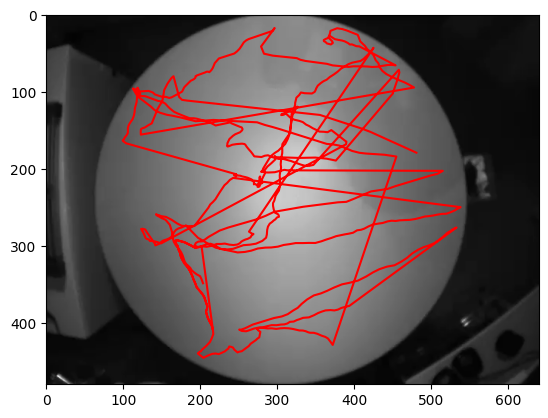

In [7]:
# show first frame as image
ret, frame = cap.read()

# plot trajectory of mouse on top of frame to check if coordinate systems match
plt.plot(df[('nose', 'x')], df[('nose', 'y')], color='red')
plt.imshow(frame)
plt.show()

# yes they match

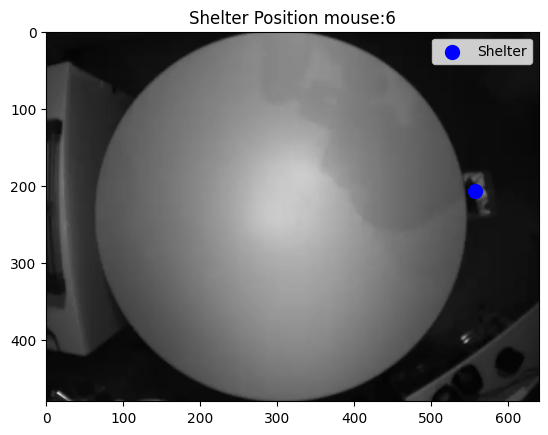

In [8]:
# determine shelter position

# define a point and visualize it
shelter_pos = (557, 206)  # example coordinates, replace with actual clicked coordinates
plt.imshow(frame)
plt.scatter(*shelter_pos, color='blue', s=100, label='Shelter')
plt.legend()
plt.title('Shelter Position mouse:{mouse_id}'.format(mouse_id=mouse_id))
plt.show()

In [9]:
# write shelter pos for each mouse into a dataframe manually
shelter_positions = {
    1: (930, 320),
    2: (999, 999),
    3: (920, 330),
    4: (577, 190),
    5: (590, 187),
    6: (557, 206),
}

shelter_df = pd.DataFrame.from_dict(shelter_positions, orient='index', columns=['shelter_x', 'shelter_y'])
shelter_df.index.name = 'mouse_id'
shelter_df

,shelter_x,shelter_y
mouse_id,,
1,930,320
2,999,999
3,920,330
4,577,190
5,590,187
6,557,206


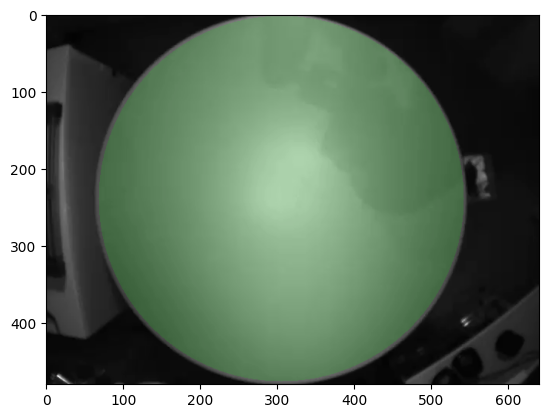

In [10]:
# determine middle and radius of of table

table_center = (305, 239)
table_radius = 237

# draw transpartent circle on frame to check
overlay = frame.copy()
cv2.circle(overlay, table_center, table_radius, (0, 255, 0), -1)
plt.imshow(frame)

# show transparent circle
alpha = 0.15  # transparency factor
plt.imshow(overlay, alpha=alpha)
plt.show()

In [11]:
# write table center and radius for each mouseinto dataframe
table_centers = {
    1: (537, 385),
    2: (999, 999),
    3: (516, 383),
    4: (330, 241),
    5: (345, 242),
    6: (305, 239),
}

table_radii = {
    1: 378,
    2: 999,
    3: 378,
    4: 237,
    5: 238,
    6: 237,
}
table_df = pd.DataFrame.from_dict(table_centers, orient='index', columns=['table_center_x', 'table_center_y'])
table_df.index.name = 'mouse_id'
table_df['table_radius'] = pd.Series(table_radii)
table_df


,table_center_x,table_center_y,table_radius
mouse_id,,,
1,537,385,378
2,999,999,999
3,516,383,378
4,330,241,237
5,345,242,238
6,305,239,237


# homing vector analysis 

In [24]:
# calculate angle between head direction and shelter direction
def calculate_head_shelter_angle(row, shelter_x, shelter_y):
    # head direction vector
    head_dir = np.array([row[('head_dir', 'x')], row[('head_dir', 'y')]])
    
    # shelter direction vector
    shelter_dir = np.array([shelter_x - row[('head', 'x')], shelter_y - row[('head', 'y')]])
    
    # calculate angle in degrees
    cos_angle = np.dot(head_dir, shelter_dir) / (np.linalg.norm(head_dir) * np.linalg.norm(shelter_dir))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    return np.degrees(angle)

In [29]:
# calculate homing vector for each frame
shelter_x, shelter_y = shelter_positions[mouse_id]
df[('homing vector', 'angle')] = df.apply(calculate_head_shelter_angle, axis=1, args=(shelter_x, shelter_y))


## trial based average

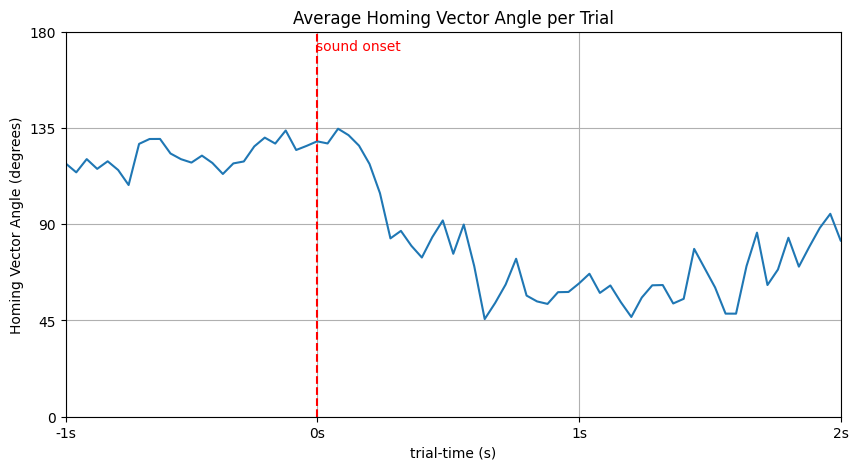

In [14]:
# trial based average for homing vector angle
trial_avg = df[('homing vector', 'angle')].groupby(level="frame_no").mean()

# plot trial averages
plt.figure(figsize=(10, 5))
plt.plot(trial_avg.values)
plt.title('Average Homing Vector Angle per Trial')
plt.xlim(0, 74)
plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"]);
plt.yticks([0, 45, 90, 135, 180]);
plt.xlabel('trial-time (s)')
plt.ylabel('Homing Vector Angle (degrees)')
plt.grid()
# vertical line at time 0 with label "sound onset"
plt.axvline(x=24, color='red', linestyle='--')
plt.text(32, plt.ylim()[1] - 10, 'sound onset', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.show()

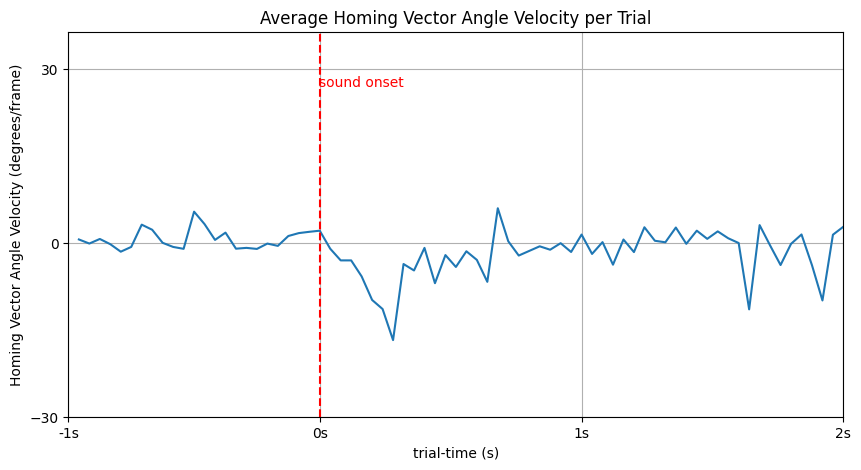

In [15]:
# trial based head angle velocity
df[("homing vector", "angle_velocity")] = df[('homing vector', 'angle')].groupby(level='trial_number').diff()
df

# plot trial based average for homing vector angle velocity
trial_avg_velocity = df[('homing vector', 'angle_velocity')].groupby(level="frame_no").mean()
plt.figure(figsize=(10, 5))
plt.plot(trial_avg_velocity.values)
plt.title('Average Homing Vector Angle Velocity per Trial')
plt.xlim(0, 74)
plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"]);
plt.yticks([-30, 0, 30]);
plt.xlabel('trial-time (s)')
plt.ylabel('Homing Vector Angle Velocity (degrees/frame)')
plt.grid()

# vertical line at time 0 with label "sound onset"
plt.axvline(x=24, color='red', linestyle='--')
plt.text(32, plt.ylim()[1] - 10, 'sound onset', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.show();

In [16]:
def get_homing_vector_and_angle_velocity(mouse_id, likelihood_threshold=0.3):
    # function to analyse homing vector for a given mouse_id
    df = pd.read_csv(f'../data/A{mouse_id}/trials.csv', header=[0, 1], index_col=[0, 1])
    
    # let frame number start at 0 for each trial
    df = df.reset_index()
    df["frame_no"] = df.groupby('trial_number')['frame'].apply(lambda x: x - x.min()).values
    df = df.set_index(['trial_number', 'frame_no'])

    # calculate head angle
    # middle point between ears
    df[('head', 'x')] = (df[('left_ear', 'x')] + df[('right_ear', 'x')]) / 2
    df[('head', 'y')] = (df[('left_ear', 'y')] + df[('right_ear', 'y')]) / 2
    # head direction vector
    df[('head_dir', 'x')] = df[('nose', 'x')] - df[('head', 'x')]
    df[('head_dir', 'y')] = df[('nose', 'y')] - df[('head', 'y')]

    # fill rows with NaN if any likelihood is below .3
    for part in ['nose', 'left_ear', 'right_ear']:
        df.loc[df[(part, 'likelihood')] < likelihood_threshold, (part, 'x')] = np.nan
        df.loc[df[(part, 'likelihood')] < likelihood_threshold, (part, 'y')] = np.nan
    
    # set whole rows to NaN if any part is NaN
    df = df.dropna(subset=[('nose', 'x'), ('left_ear', 'x'), ('right_ear', 'x'),
                           ('nose', 'y'), ('left_ear', 'y'), ('right_ear', 'y')], how='any')


    # calculate homing vector angle
    shelter_x, shelter_y = shelter_positions[mouse_id]
    df[('homing vector', 'angle')] = df.apply(calculate_head_shelter_angle, axis=1, args=(shelter_x, shelter_y))

    # calculate homing vector angle velocity
    df[("homing vector", "angle_velocity")] = df[('homing vector', 'angle')].groupby(level='trial_number').diff()
    return df

In [17]:
def plot_homing_vector_analysis(mouse_id, likelihood_threshold=0.3, save_figures=False):
    df = get_homing_vector_and_angle_velocity(mouse_id, likelihood_threshold)

    
    # trial based average for homing vector angle
    trial_avg = df[('homing vector', 'angle')].groupby(level="frame_no").mean()

    # plot trial averages
    plt.figure(figsize=(10, 5))
    plt.plot(trial_avg.values)
    plt.title(f'Mouse {mouse_id}: Average Homing Vector Angle')
    plt.xlim(0, 74)
    plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"]);
    plt.yticks([0, 45, 90, 135, 180]);
    plt.xlabel('trial-time (s)')
    plt.ylabel('Homing Vector Angle (degrees)')
    plt.grid()
    # vertical line at time 0 with label "sound onset"
    plt.axvline(x=24, color='red', linestyle='--')
    plt.text(32, plt.ylim()[1] - 10, 'sound onset', color='red', verticalalignment='bottom', horizontalalignment='right')
    plt.show()



    # trial based head angle velocity
    trial_avg_velocity = df[('homing vector', 'angle_velocity')].groupby(level="frame_no").mean()
    plt.figure(figsize=(10, 5))
    plt.plot(trial_avg_velocity.values)
    plt.title(f'Mouse {mouse_id}: Average Homing Vector Angle Velocity')
    plt.xlim(0, 74)
    plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"]);
    plt.yticks([-30, 0, 30]);
    plt.xlabel('trial-time (s)')
    plt.ylabel('Homing Vector Angle Velocity (degrees/frame)')
    plt.grid()

    # vertical line at time 0 with label "sound onset"
    plt.axvline(x=24, color='red', linestyle='--')
    plt.text(32, plt.ylim()[1] - 10, 'sound onset', color='red', verticalalignment='bottom', horizontalalignment='right')
    plt.show()

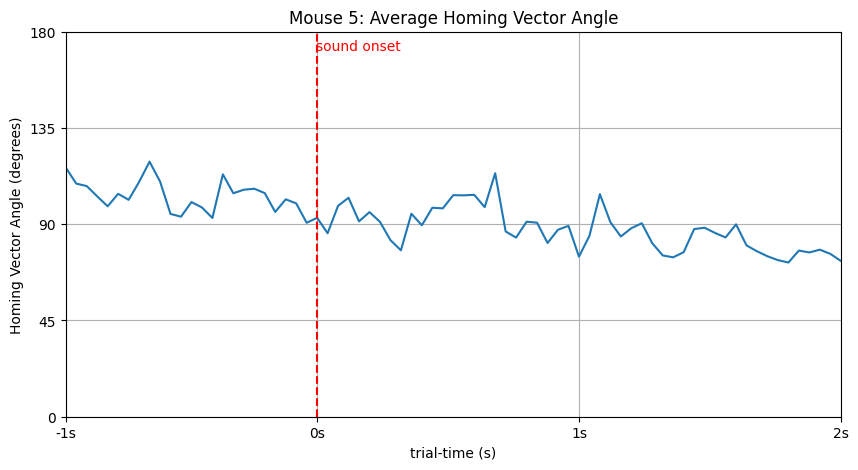

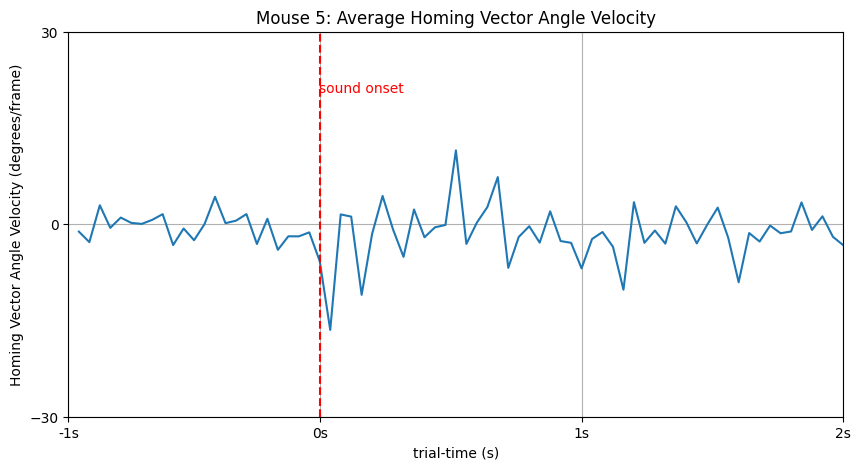

In [18]:
plot_homing_vector_analysis(5)

In [19]:
# write plots to pdf
from matplotlib.backends.backend_pdf import PdfPages

for mouse_id in [1, 3, 4, 5]:
    
    with PdfPages(f'../results/A{mouse_id}_homing_vector_analysis.pdf') as pdf:
        df = get_homing_vector_and_angle_velocity(mouse_id)
        
        # trial based average for homing vector angle
        trial_avg = df[('homing vector', 'angle')].groupby(level="frame_no").mean()

        # plot trial averages
        plt.figure(figsize=(10, 5))
        plt.plot(trial_avg.values)
        plt.title(f'Mouse {mouse_id}: Average Homing Vector Angle')
        plt.xlim(0, 74)
        plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"]);
        plt.yticks([45, 90, 135]);
        plt.xlabel('trial-time (s)')
        plt.ylabel('Homing Vector Angle (degrees)')
        plt.grid()
        # vertical line at time 0 with label "sound onset"
        plt.axvline(x=24, color='red', linestyle='--')
        plt.text(32, plt.ylim()[1] - 10, 'sound onset', color='red', verticalalignment='bottom', horizontalalignment='right')
        pdf.savefig()
        plt.close()

        # trial based head angle velocity
        trial_avg_velocity = df[('homing vector', 'angle_velocity')].groupby(level="frame_no").mean()
        plt.figure(figsize=(10, 5))
        plt.plot(trial_avg_velocity.values)
        plt.title(f'Mouse {mouse_id}: Average Homing Vector Angle Velocity')
        plt.xlim(0, 74)
        plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"]);
        plt.yticks([-20, 0, 20]);
        plt.xlabel('trial-time (s)')
        plt.ylabel('Homing Vector Angle Velocity (degrees/frame)')
        plt.grid()

        # vertical line at time 0 with label "sound onset"
        plt.axvline(x=24, color='red', linestyle='--')
        plt.text(32, plt.ylim()[1] - 10, 'sound onset', color='red', verticalalignment='bottom', horizontalalignment='right')
        pdf.savefig()
        plt.close()

## individual trials

In [52]:
mouse_id = 6
def calculate_homing_vector(mouse_id):
    df = pd.read_csv(f'../data/A{mouse_id}/trials.csv', header=[0, 1], index_col=[0, 1]) 
    # let frame number start at 0 for each trial
    df = df.reset_index()
    df["frame_no"] = df.groupby('trial_number')['frame'].apply(lambda x: x - x.min()).values
    df = df.set_index(['trial_number', 'frame_no'])
    # calculate head angle
    # middle point between ears
    df[('head', 'x')] = (df[('left_ear', 'x')] + df[('right_ear', 'x')]) / 2
    df[('head', 'y')] = (df[('left_ear', 'y')] + df[('right_ear', 'y')]) / 2

    # head direction vector
    df[('head_dir', 'x')] = df[('nose', 'x')] - df[('head', 'x')]
    df[('head_dir', 'y')] = df[('nose', 'y')] - df[('head', 'y')]

    # if likelyhood is below .3, set to NaN
    for part in ['nose', 'left_ear', 'right_ear']:
        df.loc[df[(part, 'likelihood')] < 0.3, (part, 'x')] = np.nan
        df.loc[df[(part, 'likelihood')] < 0.3, (part, 'y')] = np.nan


    # set whole rows to NaN if any part is NaN
    df = df.dropna(subset=[('nose', 'x'), ('left_ear', 'x'), ('right_ear', 'x'),
                        ('nose', 'y'), ('left_ear', 'y'), ('right_ear', 'y')], how='any')

    # calculate homing vector for each frame
    shelter_x, shelter_y = shelter_positions[mouse_id]
    df[('homing vector', 'angle')] = df.apply(calculate_head_shelter_angle, axis=1, args=(shelter_x, shelter_y))

    df[("homing vector", "angle_velocity")] = df[('homing vector', 'angle')].groupby(level='trial_number').diff()
    return df

In [54]:
df = calculate_homing_vector(6)

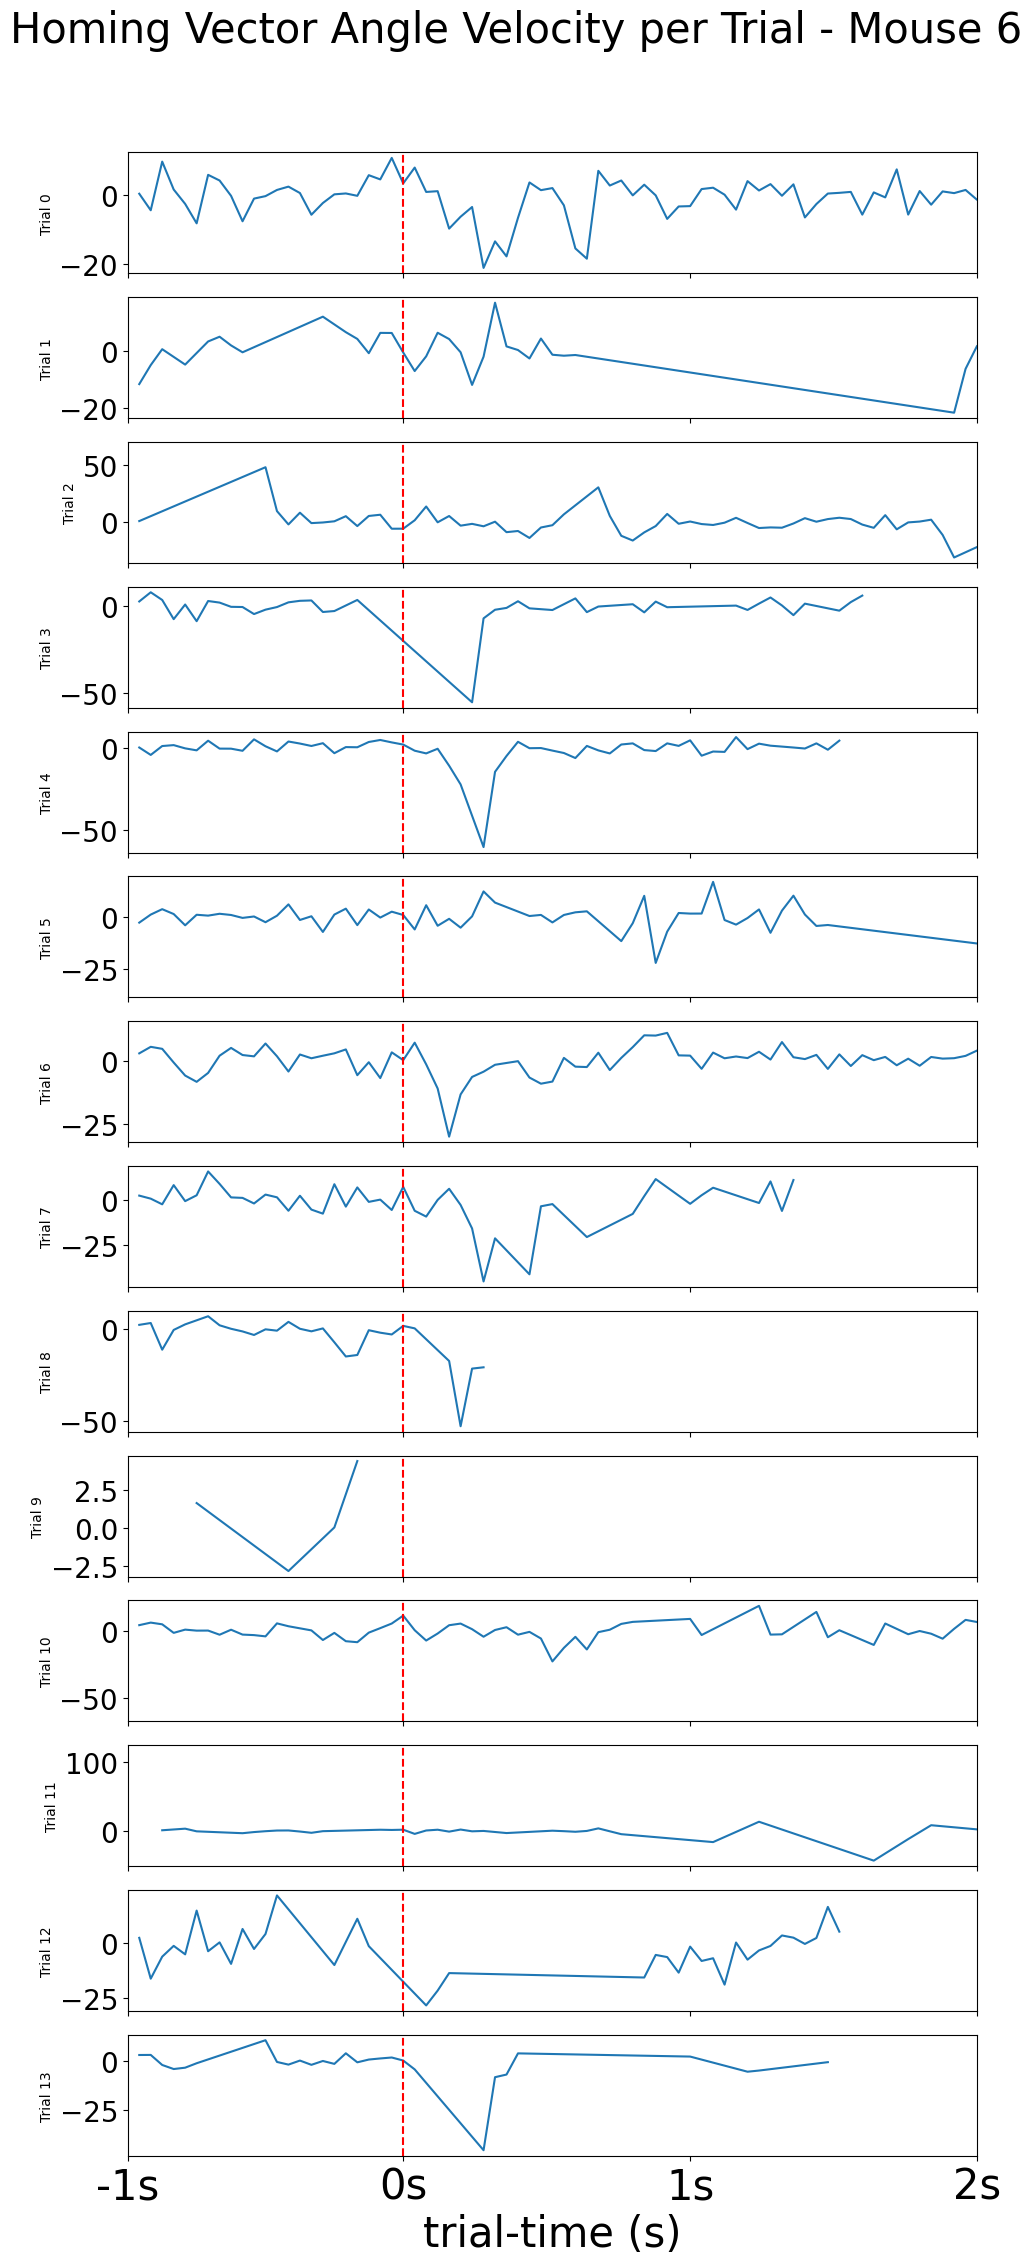

In [66]:
# plots trials underneath each other
# separate plot for each trial
trial_numbers = df.index.get_level_values('trial_number').unique()
num_trials = len(trial_numbers)

fig, axes = plt.subplots(num_trials, figsize=(10, 1.7 * num_trials), sharex=True, sharey=False)
fig.suptitle('Homing Vector Angle Velocity per Trial - Mouse {mouse_id}'.format(mouse_id=mouse_id), size=30)
for i, trial_number in enumerate(trial_numbers):
    trial_data = df.xs(trial_number, level='trial_number')
    axes[i].plot(trial_data.index.get_level_values('frame_no'), trial_data[('homing vector', 'angle_velocity')])
    #axes[i].set_title(f'Trial {trial_number}')
    axes[i].set_xlim(0, 74)
    axes[i].set_ylabel('Trial {trial_number}'.format(trial_number=trial_number))
    axes[i].axvline(x=24, color='red', linestyle='--')
    # make y ticks larger
    axes[i].tick_params(axis='y', labelsize=20)
    if i == num_trials - 1:
        axes[i].set_xlabel('trial-time (s)', size = 30)
        axes[i].set_xticks([0, 24, 49, 74])
        axes[i].set_xticklabels(["-1s", "0s", "1s", "2s"], size=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

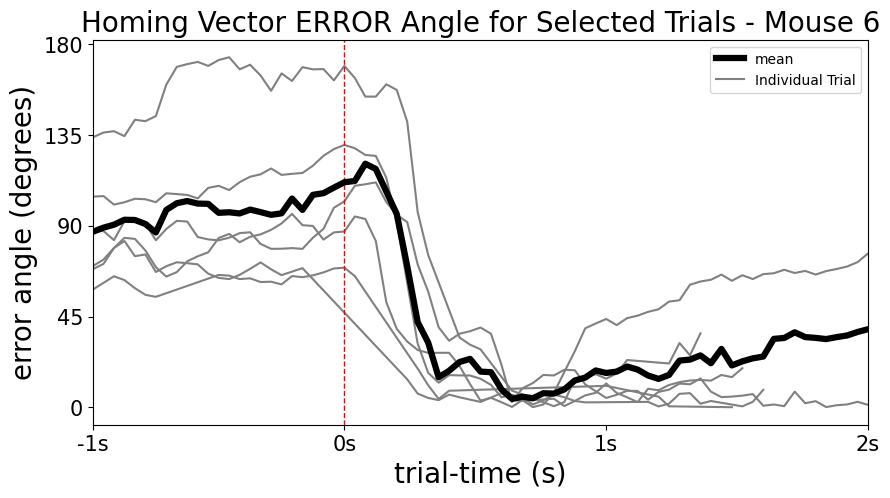

In [90]:
# select trials
selected_trials = [0, 3, 4, 6, 7, 13]

plt.figure(figsize=(10, 5))
# plot homing vector angle for selected trials
for trial_number in selected_trials:
    trial_data = df.xs(trial_number, level='trial_number')
    plt.plot(trial_data.index.get_level_values('frame_no'), trial_data[('homing vector', 'angle')], color="grey")
# plot mean across selected trials, select trials from df to do so df.xs(selected_trials, level='trial_number') doesnt work 
selected_data = df.loc[selected_trials]
mean_selected = selected_data[('homing vector', 'angle')].groupby(level='frame_no').mean()
# indicate start of trial with vertical line
plt.axvline(x=24, color='red', linestyle='--', linewidth=1)
plt.plot(mean_selected.index.get_level_values('frame_no'), mean_selected.values, label='mean', color='black', linewidth=4.5)
plt.xlabel('trial-time (s)', size=20)
plt.ylabel('error angle (degrees)', size=20)
plt.title('Homing Vector ERROR Angle for Selected Trials - Mouse {mouse_id}'.format(mouse_id=mouse_id), size=20)
plt.xlim(0, 74)
plt.xticks([0, 24, 49, 74], labels=["-1s", "0s", "1s", "2s"], size=15);
plt.yticks([0, 45, 90, 135, 180], size=15);

# custimize legend, plot one grey line with label "Individual Trials"
plt.plot([], [], color='grey', label='Individual Trial')
plt.legend()
plt.show()